# Запрос перечня друзей пользователя
Для выполнения работы импортируем необходимый пакет

In [ ]:
!pip install vk_api

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48 kB 2.9 MB/s 


In [ ]:
import vk_api

Как и при выполнении первой лабараторной работы создаем подключение, а далее находим друзей `user1` с помощью метода `friends.get`

In [ ]:
def auth_handler():
    """При двухфакторной аутентификации вызывается эта функция"""
    key = input("Enter authentication code: ")
    remember_device = True
    return key, remember_device

def stop_f(items):
    print(items)

def auth(login:str, psswd:str):
    vk_session = vk_api.VkApi(login, psswd, auth_handler=auth_handler)
    try:
        vk_session.auth()
    except vk_api.AuthError as error_msg:
        print(error_msg)
    
    return vk_session

In [ ]:
vk_session = auth(" ", " ")
tools = vk_api.VkTools(vk_session)

In [ ]:
import time
def get_groups_users(friend_list, tools):
    friends_out = {}
    for friend in friend_list:
        try:
            friends_out[friend] = tools.get_all("friends.get", 100, {"user_id": friend})
        except Exception:
            friends_out[friend] = []
        time.sleep(1)
    return friends_out

In [ ]:
user1 = 251901521
friend_list = []
friend_list.append(user1)
friends_out = get_groups_users(friend_list, tools)
print(friends_out)

In [ ]:
friends_of_friends_list = get_groups_users(friends_out[user1]['items'], tools)
print(friends_of_friends_list)

In [ ]:
list(friends_of_friends_list)
for id in list(friends_of_friends_list):
    try:
        print(len(friends_of_friends_list[id]["items"]))
    except:
        print(f"error for id:{id}")

## Создание простого графа
Установим модуль **networkX** (необходима версия 1.9)

In [ ]:
import networkx as nx
import numpy.random as rnd
import matplotlib.pyplot as plt
import itertools

Создадим экземпляр класса `nx.Graph`

In [ ]:
graph = nx.Graph()
graph

Чтобы добавить вершину, используем метод `add_note()`

In [ ]:
graph.add_node('A')
graph.add_node('B')
graph.add_node('C')
graph.add_node('D')
graph.add_node('E')
graph.nodes()


Т.к. метод `add_edge`, соединяет первую вершину со второй, но не наоборот, напишем свою функцию для добавления ребер.

In [ ]:
def add_edge(f_item, s_item, graph=None):
  graph.add_edge(f_item, s_item)
  graph.add_edge(s_item, f_item)

Теперь добавим несколько ребер, а также визуализируем граф:

In [ ]:
add_edge('A', 'B', graph=graph)
add_edge('B', 'C', graph=graph)
add_edge('D', 'B', graph=graph)
add_edge('D', 'A', graph=graph)
add_edge('E', 'A', graph=graph)
add_edge('E', 'B', graph=graph)

In [ ]:
nx.draw_circular(graph,
                 node_color='red',
                 node_size=1000,
                 with_labels=True)

Также мы можем создать вершины графа, воспользовавшись методом `add_nodes_from()`, передав туда итерируемый объект. Также работает и с методом `add_edges_from()`, где аргумент должен содержать кортежи с вершинами.

In [ ]:
cities = [
    "A",
    "B",
    "C",
    "D"
]
graph = nx.Graph()
graph.add_nodes_from(cities)

Теперь добавим ребра с весами (в нашем случае это расстояние между городами А, В, С и D):

In [ ]:
distances = [
    ('A', 'B', 0.15),
    ('B', 'C', 0.16),
    ('B', 'D', 0.25),
    ('C', 'D', 0.14),
    ('D', 'A', 0.18)
]
graph.add_weighted_edges_from(distances)

In [ ]:
pos = nx.spring_layout(graph)
edge_labels = nx.get_edge_attributes(graph, "weight")
nx.draw_networkx_edge_labels(graph, pos, edge_labels)

Данная функция создает граф, вершинами которого являются узлы, содержащие `id` друзей, а также связывает между собой пользователя и его друга. Так как необходимо связать не только пользователя и друзей, а еще друзей между собой, то модифицируем код следующим образом.

In [ ]:
def make_graph(friends_out, friends_friends):
  graph = nx.Graph()
  graph.add_node(user1, size = friends_out[user1]['count'])

  for i in friends_out[user1]['items']:
    try:
      graph.add_node(i, size = friends_friends[i]['count'])
      intersection = set(friends_out[user1]['items']).intersection(
        set(friends_friends[i]['items']))
      graph.add_edge(user1, i, weight=len(intersection))
    except Exception:
      print("err")

  for i in range(len(friends_out[user1]['items'])):
    id1 = friends_out[user1]['items'][i]
    for k in range(i+1, len(friends_out[user1]['items'])):
      id2 = friends_out[user1]['items'][k]
      try:
        intersection = set(friends_friends[id1]['items']).intersection(
          set(friends_friends[id2]['items']))
        if len(intersection) > 0:
          graph.add_edge(id1, id2, weight=len(intersection))
      except Exception:
        print("err friend")
  return graph

## Создание полносвязного графа
Полносвязный граф - граф, где каждая вершина соединена с каждой другой.

In [ ]:
def complete_graph(N: int) -> nx.Graph:
  graph = nx.Graph()
  N_range = range(N)
  all_paris = itertools.permutations(N_range, 2)

  graph.add_nodes_from(N_range)
  graph.add_edges_from(all_paris)

  return graph

In [ ]:
compl_graph = complete_graph(15)

nx.draw_circular(compl_graph, 
         node_color='green',
         node_size=750,
         with_labels=True)

## определение полноты графа
Теперь определим критерий, когда граф является полным.

В полном графе n(n-1)/2 ребер, т.к. каждая вершина соединена с каждой, а при таком подсчете одно ребро считается дважды.

Мы уже знаем о методах `node()` и `edges()`, возвращающие список вершин и ребер. Поэтому с помощью функции `len()` мы можем узнать кол-во вершин и ребер.

In [ ]:
def is_complete(graph:nx.Graph) -> bool:
  edges = len(graph.edges())
  nodes = len(graph.nodes())

  return edges == nodes * (nodes - 1) / 2

In [ ]:
is_complete(compl_graph)

True

In [ ]:
is_complete(graph)

False

## Создание графа друзей

In [ ]:
friends_out[user1]["items"]

In [ ]:
friend_graph = nx.Graph()
friend_graph.add_nodes_from(friends_out[user1]["items"])
graph.add_node(user1)

In [ ]:
for id in friends_out[user1]["items"]:
  add_edge(user1, id, graph=friend_graph)

In [ ]:
nx.draw_circular(friend_graph, 
         node_color='green',
         node_size=200,
         with_labels=True)

In [ ]:
for user in list(friends_of_friends_list)[:1]:
  try:
    for id in friends_of_friends_list[user]["items"]:
      graph.add_node(id)
      add_edge(user, id, graph=friend_graph)
  except:
    pass


In [ ]:
nx.draw_circular(friend_graph, 
         node_color='green',
         node_size=50)

In [ ]:
nx.draw(friend_graph,node_color='#A0CBE2',edge_color='#BB0000',width=1,edge_cmap=plt.cm.Blues)
plt.savefig("friend_graph.svg")

# Задания
## Постройте матрицу смежности заданных графов

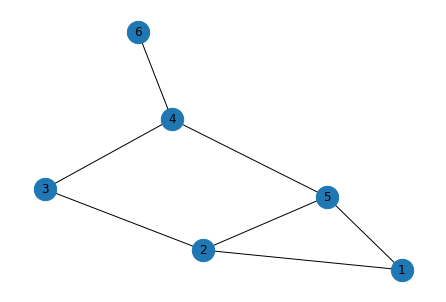

In [ ]:
graph_1 = nx.Graph()
edges_1 = [
    (1, 2),
    (1, 5),
    (2, 5),
    (2, 3),
    (3, 4),
    (5, 4),
    (4, 6)
]
nodes_1 = [1,2,3,4,5,6]
graph_1.add_nodes_from(nodes_1)
graph_1.add_edges_from(edges_1)
nx.draw(graph_1,
        with_labels=True,
        node_size = 500)

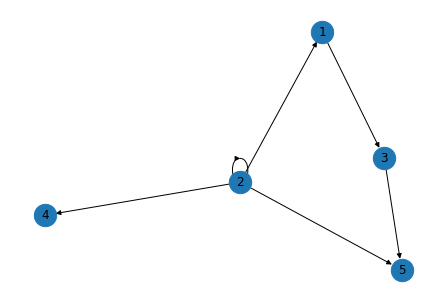

In [ ]:
graph_2 = nx.DiGraph()
edges_2 = [
    (2, 2), (2, 1), (2, 4), (2, 5),
    (1, 3),
    (3, 5)
]
graph_2.add_edges_from(edges_2)
nx.draw(graph_2,
        with_labels=True,
        node_size = 500)

{(1, 2): Text(0.04366390253753308, -0.4297945233882515, '10'),
 (1, 3): Text(-0.016844272960554317, 0.4761399365054217, '30'),
 (1, 4): Text(0.01958803253317191, -0.046663978067103234, '50'),
 (1, 5): Text(-0.012803152004615959, 0.21093499478517846, '10'),
 (3, 5): Text(-0.052050431702193416, 0.5466639780671033, '10'),
 (4, 3): Text(-0.019659247164405546, 0.2890650052148216, '20'),
 (4, 2): Text(0.04084892833368185, -0.6168694546788516, '40'),
 (5, 1): Text(-0.012803152004615959, 0.21093499478517846, '10'),
 (5, 3): Text(-0.052050431702193416, 0.5466639780671033, '10'),
 (5, 4): Text(-0.015618126208467187, 0.023860063494578393, '30')}

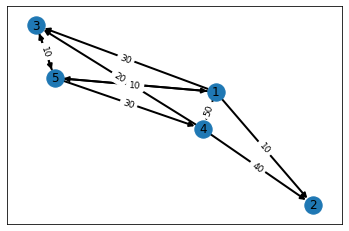

In [ ]:
graph_3 = nx.DiGraph()
edges_3 = [(1, 2, {'weight': 10}), (1, 3, {'weight': 30}), (1, 4, {'weight': 50}), (1, 5, {'weight': 10}), (3, 5, {'weight': 10}), (4, 3, {'weight': 20}), (4, 2, {'weight': 40}), (5, 1, {'weight': 10}), (5, 3, {'weight': 10}), (5, 4, {'weight': 30})]
graph_3.add_edges_from(edges_3)
pos = nx.spring_layout(graph_3)
edge_labels = nx.get_edge_attributes(graph_3, "weight")
nx.draw_networkx_nodes(graph_3, pos, node_size=300)
nx.draw_networkx_edges(graph_3, pos, width=2)
nx.draw_networkx_labels(graph_3, pos)
nx.draw_networkx_edge_labels(graph_3, pos, edge_labels, font_size=9)
